# TFM: Reconocimiento de imagenes 

## Primera exploracion de los datos

In [1]:
%%time
# Importacion de librerias
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import json 
from PIL import Image 
import os 
import random

CPU times: total: 1.36 s
Wall time: 1.34 s


In [2]:
# Carga de fichero 
photos = pd.read_json("photos.json", lines=True)
photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [3]:
# Muestras de cada tipo de fotografia 
photos["label"].value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

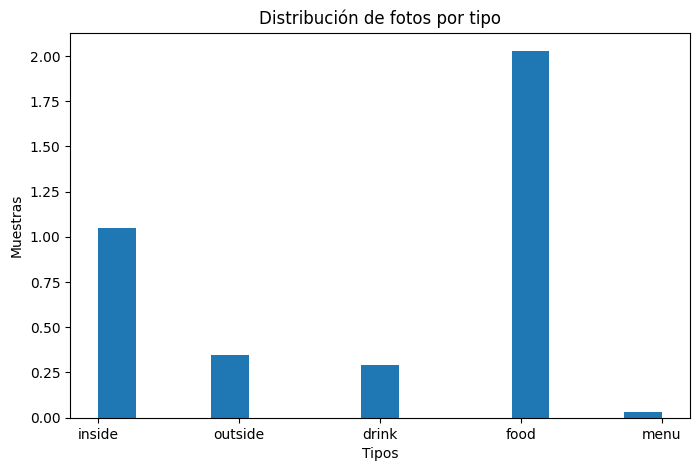

In [4]:
plt.figure(figsize=(8,5))
plt.title("Distribución de fotos por tipo")
plt.hist(x = photos["label"], bins=15, density=True)
plt.xlabel("Tipos")
plt.ylabel("Muestras")
plt.show()

## Funcion que cuenta el numero de imagenes en un documento: 

In [5]:

def counter(documento):
    count = 0  
    with open(documento, "r") as output: 
        for imagen in output: 
            count +=1 
    return f"{count} items"

In [6]:
%%time 
print(f'{counter("output/valid_photos.json")}')
print(f'{counter("photos.json")}')

190006 items
200100 items
CPU times: total: 172 ms
Wall time: 177 ms


## 1ª Limpieza del Dataset
### Eliminacion de las imagenes corruptas o con formato erroneo que no puedan abrirse
        1) Mediante una funcion
        2) Mediante Bloque de codigo

In [7]:
# 1) Funcion que depura el dataset escogiendo solo las imagenes validas

imagenes_validas = []
def valid(data):
    for img in os.listdir(data):
        ruta_img = os.path.join(data, img)
        try: 
            Image.open(ruta_img)
            imagenes_validas.append(img)
        except Exception: 
            pass
    return f"{len(imagenes_validas)} imagenes validas de {photos.shape[0]}"
    
  

In [8]:
%%time
valid("photos")

CPU times: total: 2min 37s
Wall time: 3min 53s


'190004 imagenes validas de 200100'

In [9]:
with open("output/valid_photos.json", "w") as output_doc: 
    json.dump(imagenes_validas, output_doc, indent=4)

Una vez que tenemos el json con las imagenes validas podemos volcarlo como filtro en el dataset origen para obtener un dataset sobre el que trabajar


In [10]:
with open("output/valid_photos.json") as output_doc: 

    jpg_ids = json.load(output_doc)
    valid_ids = [id_name.replace(".jpg","") for id_name in jpg_ids ]

    valid_photos = photos[photos["photo_id"].isin(valid_ids)]

valid_photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [11]:
valid_photos.to_csv("output/valid_photos.csv", index= False)

### Homogeinizacion de muestras (Downsampling)
En este paso el código acota el dataset al mínimo numero de muestras ( ~1600 )  

In [12]:
sample_size = valid_photos[valid_photos["label"] == "menu"].shape[0] # Numero de muestras que queremos para todas las etiquetas 
labels = set(valid_photos["label"].unique())  # Etiquetas de las fotos
sample_list = [] # Guardado 


for label in labels: 
    label_samples = valid_photos[valid_photos["label"] == label]["photo_id"].sample(n=sample_size, random_state= 42)
    sample_list.append(label_samples) 


In [13]:
for _ in sample_list: 
    print(len(_))  # comprobacion de que esta bien 

1593
1593
1593
1593
1593


In [14]:
all_samples = pd.concat(sample_list) # Agrupamos las listas en una ( numero de elementos la suma de las 5 ) == 7965

print(f"Numero de muestras homogeneizadas: {len(all_samples)}")

Numero de muestras homogeneizadas: 7965


In [15]:
model_photos_v1= valid_photos[valid_photos["photo_id"].isin(all_samples)] # filtramos el dataset limpio de imagenes corruptas con las muestras escogidas

# guardamos en un csv el prototipo de muestra que podria ser para modelizar
model_photos_v1.to_csv("output/model_photosv1.0.csv", index = False)

### Comentarios: 
    1. Data set con pocas muestras -> No seria mala Data Augmentation (en Keras o Tensorflow e.j )

    2. Estudiar la resolucion de las imagenes para ver si hay muchas de un tipo o si hace falta introducir resoluciones variadas (¿librerias para cambiar la resolución??) -> De cara a lo que nos dijo Pelayo acerca de la precisión en la detección de las imageness : "Entrenar con mucha resolución puede jugar en nuestra contra a la hora de modelar".

    3. Research de modelos -> pendiente ( Mirar documentacion de Pelayo)